In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchcde
import h5py
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
targetdir = '/work/hmzhao/KMT_data/'
with h5py.File(targetdir + 'processed_data.h5', mode='r') as dataset_file:
    X_even = torch.tensor(dataset_file['X'][...]).float()
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even)

In [3]:
q = torch.tensor([
    # Planet/Binary
    0.43, 0.10, 0.23, 0.045, 0.23,
    # Binary/Plan
    0.55, 0.18, 0.036, 0.048, 0.1,
    0.14, 0.17, 0.14, 0.13, 0.034,
    0.17, 0.43, 0.2,
    # Binary
    0.23, 0.356, 0.07, 0.50, 0.23, 
    0.17, 0.046, 0.4, 0.32, 0.19, 
    0.59, 0.86, 0.25, 0.37, 0.23,
    0.95, 0.58, 0.53, 0.046, 0.46,
    0.095, 0.90, 0.37, 0.36, 0.72,
    0.50, 0.11, 0.78, 0.42, 0.50,
    0.88, 0.73, 0.74, 0.15, 0.58,
    0.15, 0.43, 0.96, 0.086, 0.76,
    0.28, 0.67, 0.69, 0.23, 0.56,
    0.50, 0.08, 0.74, 0.67, 0.20
])

In [5]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_0.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = 6
input_dim = X_even.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [6]:
def get_negloglik(pi, normal, y):
    normal = torch.distributions.Normal(normal.loc[:, :, [2]], normal.scale[:, :, [2]])
    loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
    loglik = torch.sum(loglik, dim=2)
    loss = -torch.logsumexp(torch.log(pi.probs) + loglik, dim=1)
    return loss


num = len(X_even)
batchsize = len(X_even)
pred = torch.zeros((num, 6))
nll = torch.zeros((num,))
nll_sample = torch.zeros((num,))
model.eval()
for i in tqdm(range(num // batchsize)):
    torch.cuda.empty_cache()
    batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    # pred[i*batchsize:i*batchsize+batchsize] = model(batch).detach().cpu()
    pi, normal = model(batch)
    pred[i*batchsize:i*batchsize+batchsize] = model.sample(pi, normal).detach().cpu()
    nll[i*batchsize:i*batchsize+batchsize] = get_negloglik(pi, normal, torch.log10(q).reshape(-1, 1)[i*batchsize:i*batchsize+batchsize].float().to(device)).detach().cpu()
    nll_sample[i*batchsize:i*batchsize+batchsize] = get_negloglik(pi, normal, pred[i*batchsize:i*batchsize+batchsize, [2]].float().to(device)).detach().cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

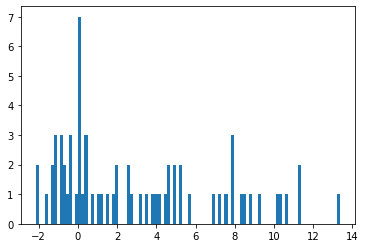

In [7]:
plt.hist(nll.numpy(), bins=100)
plt.show()

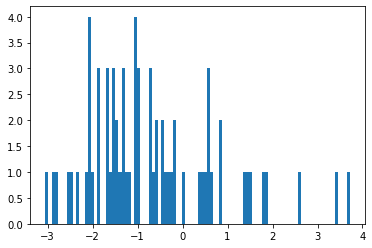

In [8]:
plt.hist(nll_sample.numpy(), bins=100)
plt.show()

In [9]:
10**pred[:, 2]


tensor([5.0865e-01, 7.7297e-04, 5.9181e-01, 3.8344e-04, 3.4136e-04, 7.8124e-01,
        8.8724e-01, 5.5706e-01, 6.2256e-01, 1.1893e-02, 2.6136e-01, 8.7031e-01,
        2.4393e-01, 1.6697e-01, 5.5725e-01, 2.9930e-01, 3.5804e-01, 3.1369e-01,
        2.3382e-01, 1.9561e-01, 3.3347e-04, 4.0834e-01, 6.9559e-01, 1.6305e-01,
        4.0619e-01, 4.2404e-01, 3.7891e-01, 2.2255e-01, 5.2727e-01, 4.7324e-01,
        1.4147e-02, 5.1108e-01, 1.0602e-03, 2.8237e-03, 6.4848e-01, 3.5332e-01,
        8.4721e-01, 2.9860e-01, 3.1176e-01, 1.6440e-01, 7.4156e-01, 4.2760e-01,
        3.4551e-03, 8.6334e-01, 4.2082e-01, 4.1559e-01, 3.6134e-02, 3.9667e-01,
        3.4393e-01, 2.7460e-01, 1.3795e-03, 5.8136e-01, 3.1298e-01, 1.0266e+00,
        3.8395e-01, 4.6434e-03, 3.0563e-01, 3.2400e-01, 5.2102e-01, 7.0853e-01,
        1.0774e+00, 3.0203e-01, 8.7394e-01, 4.5648e-01, 3.3619e-01, 1.0376e+00,
        8.9887e-01, 1.8795e+00])

In [10]:
q

tensor([0.4300, 0.1000, 0.2300, 0.0450, 0.2300, 0.5500, 0.1800, 0.0360, 0.0480,
        0.1000, 0.1400, 0.1700, 0.1400, 0.1300, 0.0340, 0.1700, 0.4300, 0.2000,
        0.2300, 0.3560, 0.0700, 0.5000, 0.2300, 0.1700, 0.0460, 0.4000, 0.3200,
        0.1900, 0.5900, 0.8600, 0.2500, 0.3700, 0.2300, 0.9500, 0.5800, 0.5300,
        0.0460, 0.4600, 0.0950, 0.9000, 0.3700, 0.3600, 0.7200, 0.5000, 0.1100,
        0.7800, 0.4200, 0.5000, 0.8800, 0.7300, 0.7400, 0.1500, 0.5800, 0.1500,
        0.4300, 0.9600, 0.0860, 0.7600, 0.2800, 0.6700, 0.6900, 0.2300, 0.5600,
        0.5000, 0.0800, 0.7400, 0.6700, 0.2000])

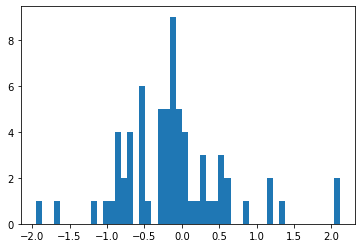

In [11]:
plt.hist(np.log10(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q)).numpy())), bins=50)
plt.show()

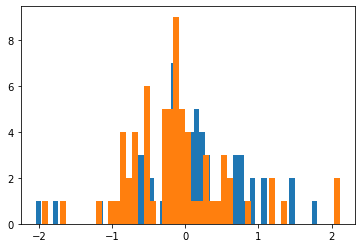

In [12]:
plt.hist(np.log10(np.abs(((torch.rand(len(q))*(-2) - torch.log10(q))/torch.log10(q)).numpy())), bins=50)
plt.hist(np.log10(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q)).numpy())), bins=50)
plt.show()

In [13]:
np.sum(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q))).numpy() < 1)/len(q)

0.6764705882352942

In [14]:
np.sum(np.abs(((torch.rand(len(q))*(-2) - torch.log10(q))/torch.log10(q))).numpy() < 1)/len(q)

0.6176470588235294

In [15]:
torch.mean((pred[:, 2] - torch.log10(q))**2)

tensor(1.0158)

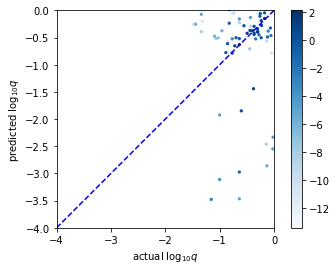

tensor([-0.3010, -1.0969, -0.1308, -0.1739, -0.6990])
[-0.34057662 -0.47342074  0.01601629 -0.04630197  0.2740385 ]
mse of log10q:  1.0157777070999146


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(torch.log10(q), pred.numpy()[:, 2], s=5, c=-nll, cmap='Blues')
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.show()
print(torch.log10(q)[-5:])
print(pred.numpy()[-5:, 2])
print('mse of log10q: ', torch.mean((torch.log10(q) -  pred.numpy()[:, 2])**2, dim=0).detach().cpu().item())

tensor(0.2300) tensor(0.2393)


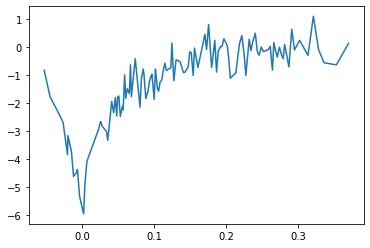

In [16]:
num = 18
print(q[num], 10**pred[num, 2])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.show()

In [133]:
# train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even[[num], :-120])

In [134]:
pi, normal = model(train_coeffs[[num]].float().to(device))

In [204]:
sample = model.sample(pi, normal).cpu().numpy()
print(sample)
print(torch.log10(q[num]))

[[ 0.9391902  -3.377015   -0.8151203   0.37125915 -0.81214774 -0.6059668 ]]
tensor(-0.6383)


In [136]:
# qsnormal = torch.distributions.Normal(normal.loc[:, :, [0, 3]], normal.scale[:, :, [0, 3]])
qsnormal = torch.distributions.Normal(normal.loc[:, :, [2, 3]], normal.scale[:, :, [2, 3]])
grid = torch.stack(torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
# grid = torch.stack(torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
prob = torch.zeros(10000, 1)
# y = torch.tile(Y[[num]], [10000, 1])
# y[:, 2:4] = grid
for i in tqdm(range(10000)):
    prob[i] = torch.exp(-model.mdn_loss(pi, qsnormal, grid[[i]].to(device)).detach().cpu())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [137]:
torch.exp(-get_negloglik(pi, normal, torch.log10(q)[[num]].to(device))).detach().cpu(), \
torch.exp(-get_negloglik(pi, normal, model.sample(pi, normal)[:, 2].to(device)).detach().cpu()), \
torch.exp(-model.mdn_loss(pi, normal, model.sample(pi, normal).to(device)).detach().cpu())

(tensor([2.2648]), tensor([1.6531]), tensor(50.0726))

tensor(-0.6383)
[[ 0.8273859  -2.8087118  -0.73488986  0.36626795 -0.79190385 -0.56393975]]


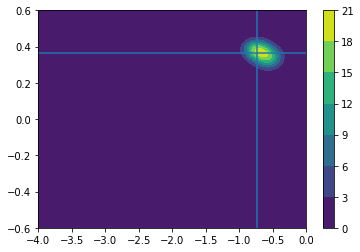

In [138]:
sample = model.sample(pi, normal).detach().cpu().numpy()
x, y = torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100))
# x, y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100))
plt.contourf(x, y, prob.reshape(100, 100))
# plt.contourf(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100), prob.reshape(100, 100).T)
# plt.hlines(Y[num, 3], 0, 1, colors='red')
# plt.vlines(Y[num, 0], -0.6, 0.6, colors='red')
# plt.hlines(sample[0, 3], 0, 1)
# plt.vlines(sample[0, 0], -0.6, 0.6)
plt.hlines(sample[0, 3], -4, 0)
plt.vlines(sample[0, 2], -0.6, 0.6)
plt.colorbar()
print(torch.log10(q)[num])
print(sample)

In [237]:
import MulensModel as mm
sample = model.sample(pi, normal).detach().cpu().numpy()
parameters = {
        't_0': 8551.968,
        't_E': 236.02,
        'u_0': 0.0390,
        'rho': 0.0028, 
        'q': 0.234, 
        's': 3.674, 
        'alpha': 3.105/np.pi*180,
    }
modelmm = mm.Model(parameters, coords=None)
times = modelmm.set_times(t_start=parameters['t_0']-2*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=1000)
modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
magnification = modelmm.get_magnification(times)
flux = 1000 * magnification + 0
mag = (22 - 2.5 * np.log10(flux) - 14.5) / 0.2
lc = np.stack([times, mag], axis=-1)

In [250]:
sample = model.sample(pi, normal).detach().cpu().numpy()
parameters = {
        't_0': 8551.968,
        't_E': 236.02,
        'u_0': 0.039,
        'rho': 0.0028, 
        'q': 10**sample[0, 2], 
        's': 10**sample[0, 3], 
        'alpha': 3.105/np.pi*180,
    }
modelmm = mm.Model(parameters, coords=None)
times = modelmm.set_times(t_start=parameters['t_0']-2*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=1000)
modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
magnification = modelmm.get_magnification(times)
flux = 1000 * magnification + 0
mag = (22 - 2.5 * np.log10(flux) - 14.5) / 0.2
lc_pred = np.stack([times, mag], axis=-1)

tensor(0.2300) 0.36935924486779687


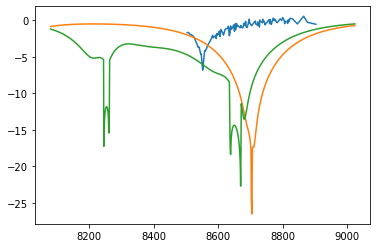

In [251]:
print(q[num], 10**sample[0, 2])
plt.plot(X_even[num, :, 0] * 236.02 * 4 + 8551.968, X_even[num, :, 1])
plt.plot(lc[:, 0], lc[:, 1])
plt.plot(lc_pred[:, 0], lc_pred[:, 1])
plt.show()

In [151]:
sample

array([[ 0.8640887 , -2.8583016 , -0.60997146,  0.4036388 , -0.92372173,
        -0.35998553]], dtype=float32)

In [161]:
Y = torch.tensor([0.039, np.log10(0.0028), np.log10(0.234), np.log10(3.674), np.cos(3.105), np.sin(3.105)]).reshape(1, -1)
print(Y)

tensor([[ 0.0390, -2.5528, -0.6308,  0.5651, -0.9993,  0.0366]],
       dtype=torch.float64)
